# PBS Analyses

In [1]:
# Import packages.
import allel
import numcodecs
import zarr
from functools import reduce
import gzip
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import math

In [92]:
# Load the 1:1 ortholog data.
ortholog_df = pd.read_csv(
    '../annotations/orthogroup_mel_san_yak_mapping.txt',
    sep='\t', names=['orthogroup', 'mel', 'san', 'yak'],
)
# Create dictionaries for mapping gene names.
san_map_dicc = {key: val for key, val in zip(ortholog_df['san'].values, ortholog_df['mel'].values)}
yak_map_dicc = {key: val for key, val in zip(ortholog_df['yak'].values, ortholog_df['mel'].values)}

In [99]:
# Load the gene family data.
obp_df = pd.read_csv(
    '../annotations/obp_orthogroups.txt',
    sep='\t', names=['orthogroup', 'mel', 'san', 'yak'],
)
or_df = pd.read_csv(
    '../annotations/or_orthogroups.txt',
    sep='\t', names=['orthogroup', 'mel', 'san', 'yak'],
)
gr_df = pd.read_csv(
    '../annotations/gr_orthogroups.txt',
    sep='\t', names=['orthogroup', 'mel', 'san', 'yak'],
)
ir_df = pd.read_csv(
    '../annotations/ir_orthogroups.txt',
    sep='\t', names=['orthogroup', 'mel', 'san', 'yak'],
)
# Intalize a dictionary.
gene_family_dicc = {
    'san': {
        'obp': obp_df['san'].values, 'or': or_df['san'].values,
        'gr': gr_df['san'].values, 'ir': ir_df['san'].values,
    },
    'yak': {
        'obp': obp_df['yak'].values, 'or': or_df['yak'].values,
        'gr': gr_df['yak'].values, 'ir': ir_df['yak'].values,
    },
}

## SNP-level PBS

In [2]:
# Define a function to load the genome wide results.
def load_genome_pbs(prefix):
    # Intialize a dictionary.
    pbs_dicc = {
        'san:yak-symp:yak-allo': {},
        'san:yak-symp:tei': {},
        'san:yak-allo:tei': {},
        'yak-symp:yak-allo:tei': {},
    }
    # For every chromosome.
    for chrom in ['2L', '2R', '3L', '3R', '4', 'X']:
        # Load the PBS resluts.
        pbs_dicc['san:yak-symp:yak-allo'][chrom] = np.loadtxt(
            f'./results/{prefix}/san_yak_symp_yak_allo_chr{chrom}_pbs.csv', delimiter=',',
        )
        pbs_dicc['san:yak-symp:tei'][chrom] = np.loadtxt(
            f'./results/{prefix}/san_yak_symp_tei_chr{chrom}_pbs.csv', delimiter=',',
        )
        pbs_dicc['san:yak-allo:tei'][chrom] = np.loadtxt(
            f'./results/{prefix}/san_yak_allo_tei_chr{chrom}_pbs.csv', delimiter=',',
        )
        pbs_dicc['yak-symp:yak-allo:tei'][chrom] = np.loadtxt(
            f'./results/{prefix}/yak_symp_yak_allo_tei_chr{chrom}_pbs.csv', delimiter=',',
        )
    return pbs_dicc

In [58]:
# Define a function to load and extract positions from a vcf file.
def load_pos(prefix):
    # Intialize a dictionary.
    pos_dicc = {}
    # For every chromosome.
    for chrom in ['2L', '2R', '3L', '3R', '4', 'X']:
        # Intialize a path.
        path = f'../zarrs/{prefix}/chr{chrom}.zarr'
        # Load the vcf file.
        callset = zarr.open_group(path, mode='r')
        # Extract the positions.
        pos_dicc[chrom] = allel.SortedIndex(callset[f'{chrom}/variants/POS'])
    return pos_dicc

In [162]:
def plot_genome_pbs(pbs_dicc, config, title, file_name):
    # Intialize figures and axes.
    plt.rcParams.update({'font.size': 8})
    fig = plt.figure(figsize=(6, 3), facecolor='white', constrained_layout=True, dpi=300)
    ax = fig.add_subplot(111)
    # Intialize the alternating colors.
    colors = ['tab:blue', 'tab:orange']
    # Intialize a list for label positions.
    x_labels_pos = []
    # Intialize a chromosome index tracker.
    idx = 0
    # Intialize a variable to store the genome length.
    genome_len = 0
    # Intialize a list store all pbs results.
    all_pbs = np.array([])
    # Intialize a list of chromosomes.
    chrom_list = ['2L', '2R', '3L', '3R', '4', 'X']
    # For every chromosome.
    for chrom in chrom_list:
        # Updated the total pbs array.
        all_pbs = np.append(all_pbs, pbs_dicc[config][chrom])
        # Determine the observed chromosome size.
        chrom_len = pbs_dicc[config][chrom].size
        # Update the observed genome length.
        genome_len += chrom_len
        # Determine the start, end, and mid point positions for the chromosomes.
        start_pos = genome_len - chrom_len
        end_pos = start_pos + chrom_len
        mid_pos = end_pos - ((end_pos - start_pos) / 2)
        # Convert negative and missing values to 0.
        pbs_no_neg = np.where((pbs_dicc[config][chrom] < 0) , 0, pbs_dicc[config][chrom])
        pbs = np.where(np.isnan(pbs_no_neg) , 0, pbs_no_neg)
        # Plot the pbs values.
        ax.plot(
            np.arange(start_pos, end_pos), pbs,
            ls='', marker='o', ms=3, color=colors[abs(idx)], alpha=0.25,
        )
        # Update the index.
        idx = abs(idx - 1)
        # Record the midpoint for labeling.
        x_labels_pos.append(mid_pos)
    # Plot the signicance threshold.
    ax.axhline(
        np.nanpercentile(all_pbs, 99), 0, 1,
        color='black', ls='dashed', lw=1,
    )
    # Plot the x-axis.
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(chrom_list)
    ax.set_xlabel('Chromosome')
    # Plot the y-axis.
    ax.set_ylim((0, 1))
    ax.set_ylabel(r'$PBS_{n1}$')
    # Despine the axes.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Plot the title.
    ax.set_title(title)
    # Show the plot.
    plt.savefig(
        f'./figures/{file_name}.png', format='png',
        facecolor='white', bbox_inches='tight', dpi=300,
    )
    plt.show()
    return

In [3]:
# Load the PBS results.
san_genome_dicc = load_genome_pbs('san')
yak_genome_dicc = load_genome_pbs('yak')

In [55]:
# For every configuration.
for key in san_genome_dicc.keys():
    # Intialize an empty array.
    san_genome_dicc[key]['all'] = np.array([])
    # For every chromosome.
    for chrom in san_genome_dicc[key].keys():
        # Update the array.
        san_genome_dicc[key]['all'] = np.append(san_genome_dicc[key]['all'], san_genome_dicc[key][chrom])

In [56]:
# For every configuration.
for key in yak_genome_dicc.keys():
    # Intialize an empty array.
    yak_genome_dicc[key]['all'] = np.array([])
    # For every chromosome.
    for chrom in yak_genome_dicc[key].keys():
        # Update the array.
        yak_genome_dicc[key]['all'] = np.append(yak_genome_dicc[key]['all'], yak_genome_dicc[key][chrom])

In [145]:
# Load the observed positions.
san_pos_dicc = load_pos('san')
yak_pos_dicc = load_pos('yak')

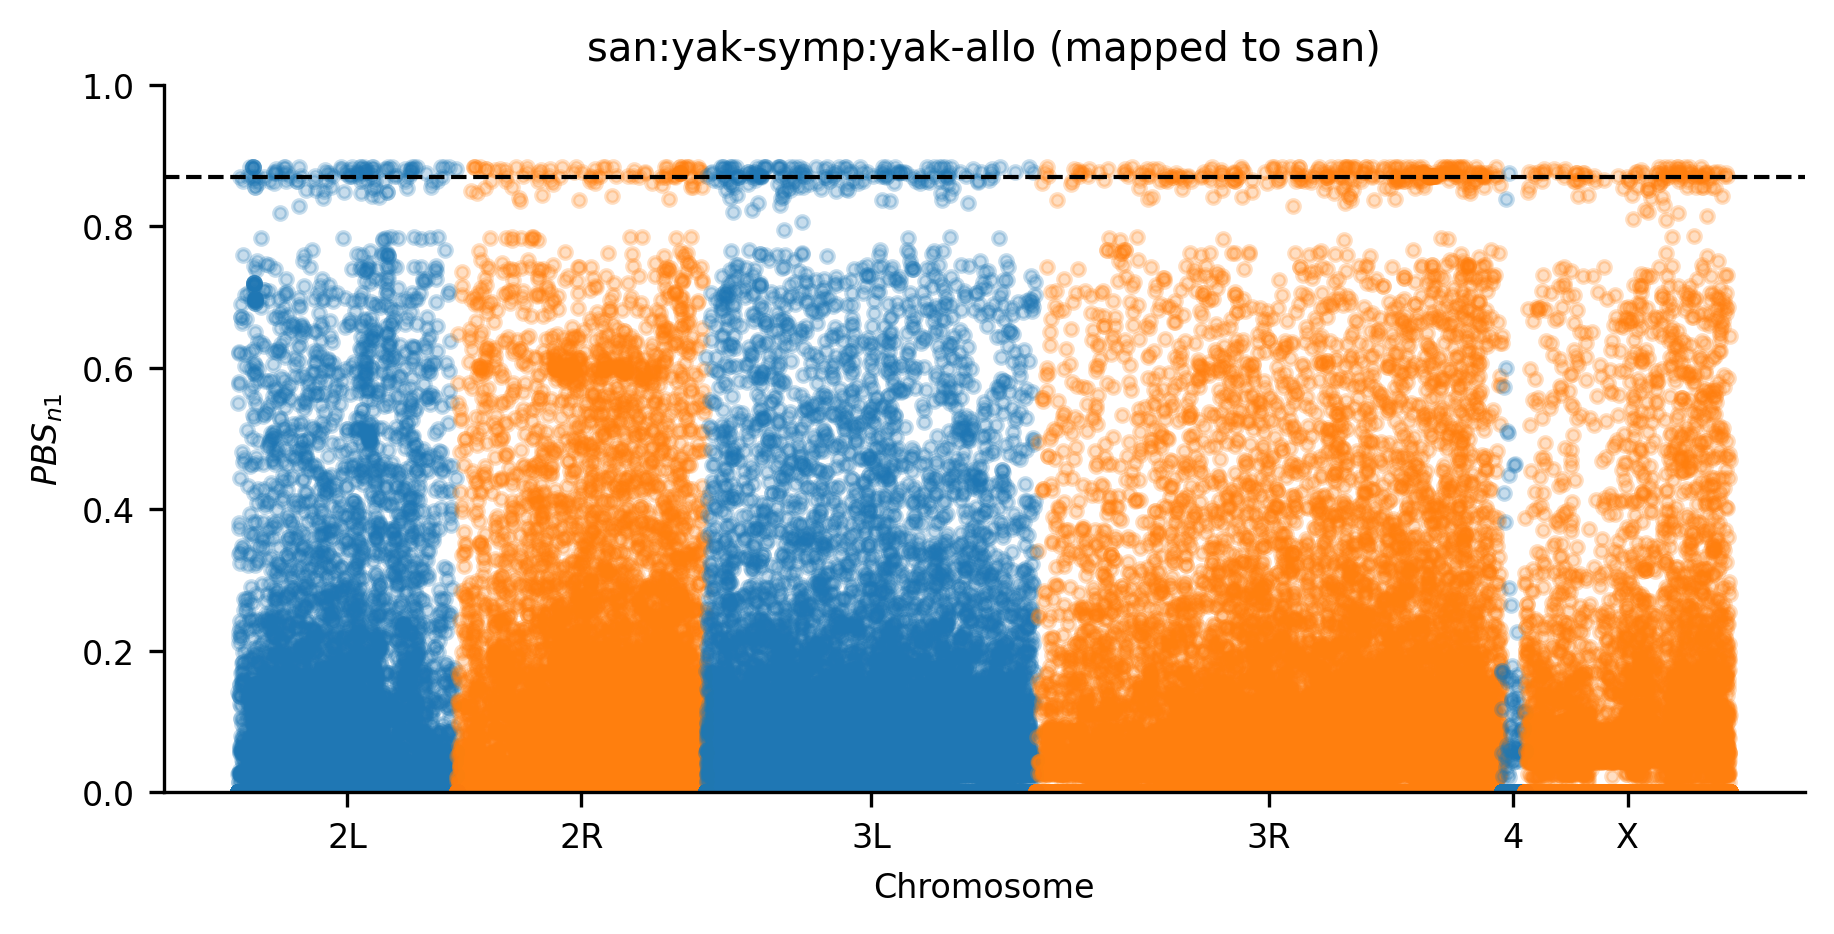

In [163]:
plot_genome_pbs(
    san_genome_dicc, 'san:yak-symp:yak-allo',
    'san:yak-symp:yak-allo (mapped to san)',
    'san_yak_symp_yak_allo_map_san_pbs',
)

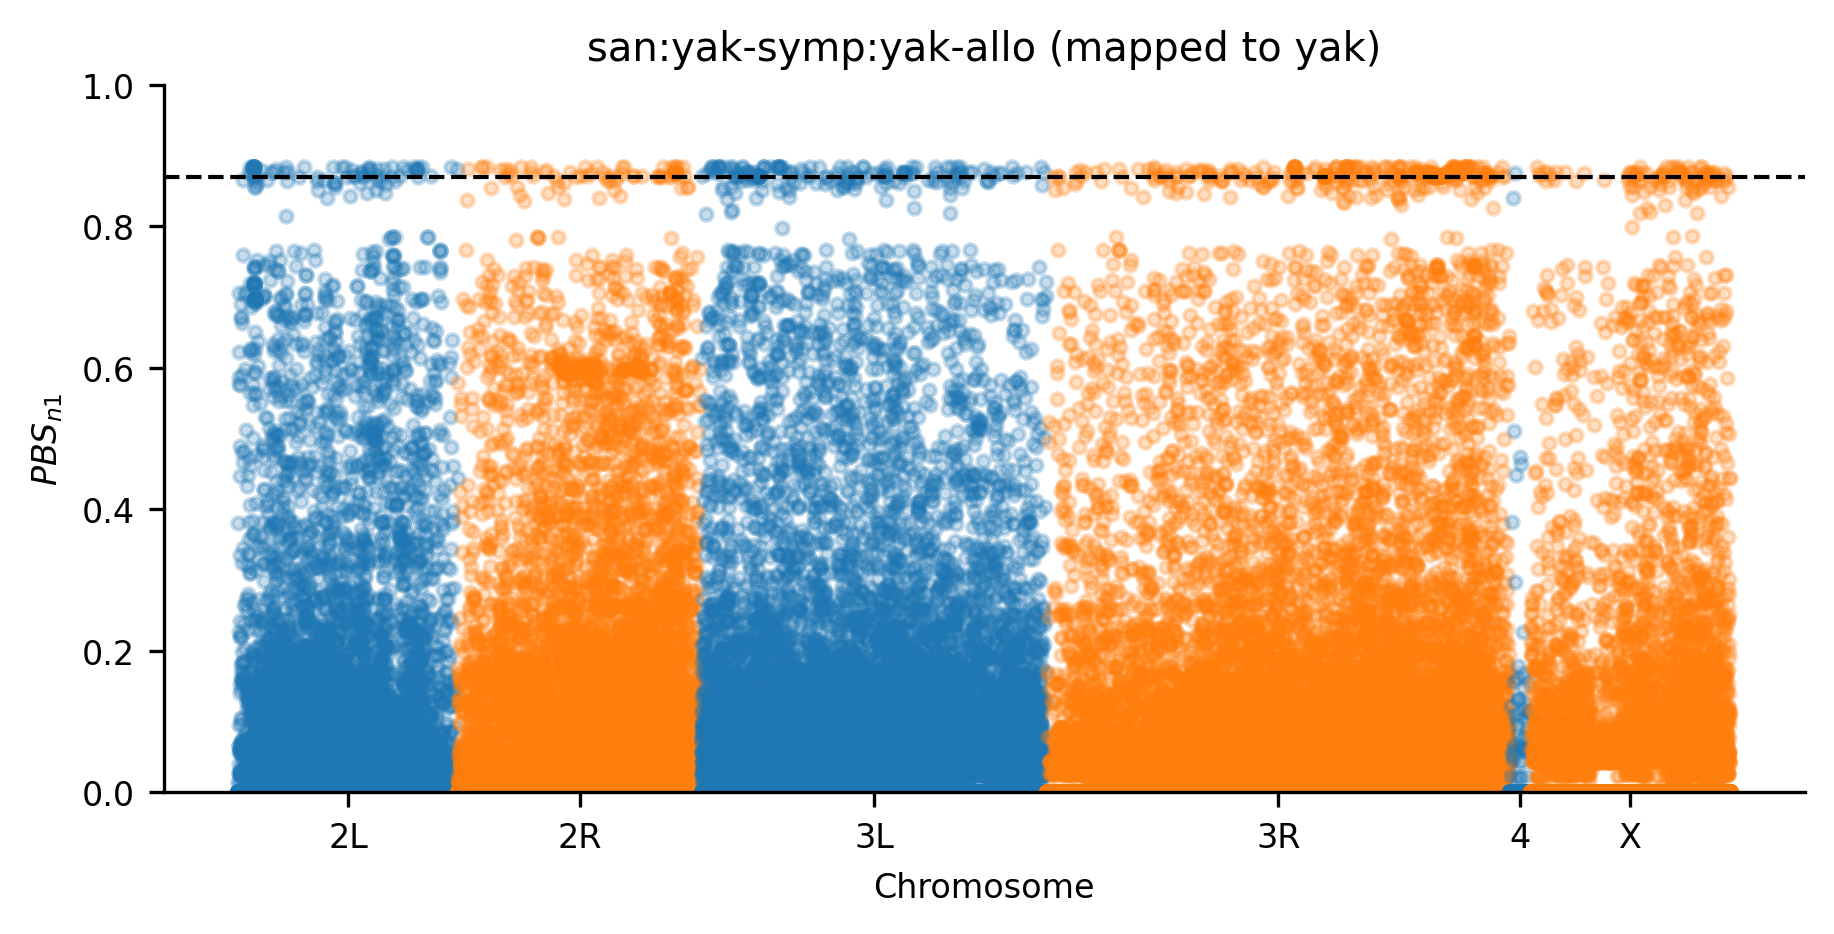

In [164]:
plot_genome_pbs(
    yak_genome_dicc, 'san:yak-symp:yak-allo',
    'san:yak-symp:yak-allo (mapped to yak)',
    'san_yak_symp_yak_allo_map_yak_pbs',
)

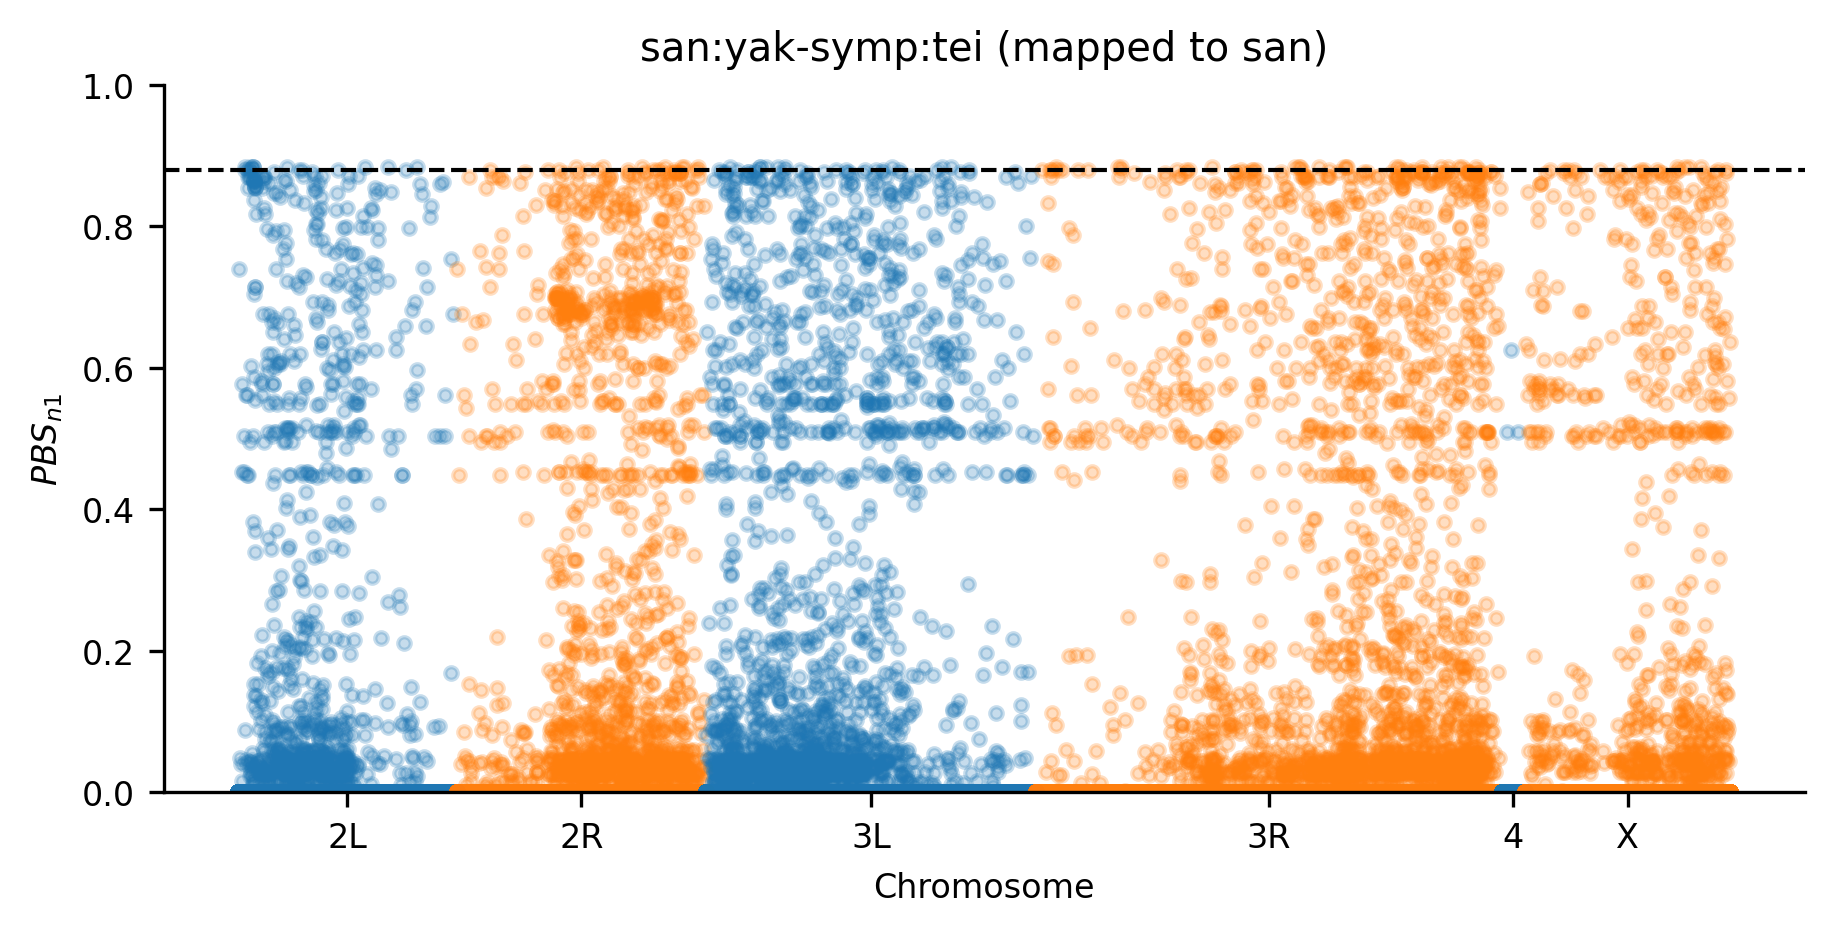

In [165]:
plot_genome_pbs(
    san_genome_dicc, 'san:yak-symp:tei',
    'san:yak-symp:tei (mapped to san)',
    'san_yak_symp_tei_map_san_pbs',
)

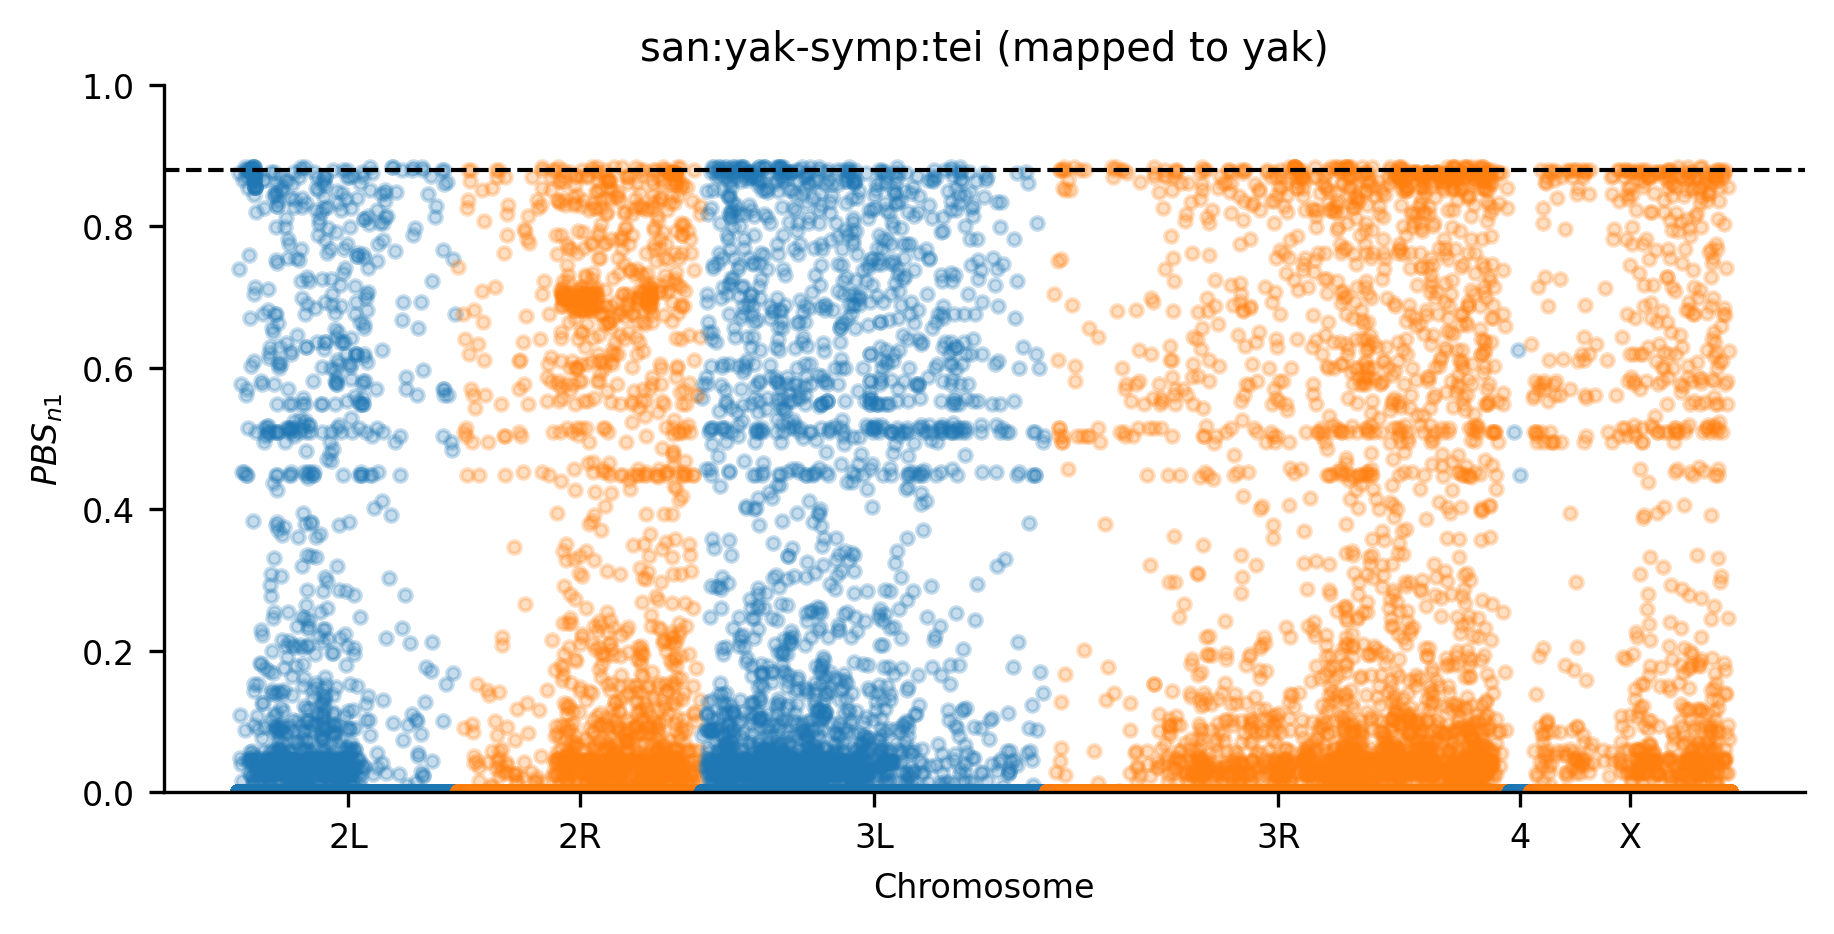

In [166]:
plot_genome_pbs(
    yak_genome_dicc, 'san:yak-symp:tei',
    'san:yak-symp:tei (mapped to yak)',
    'san_yak_symp_tei_map_yak_pbs',
)

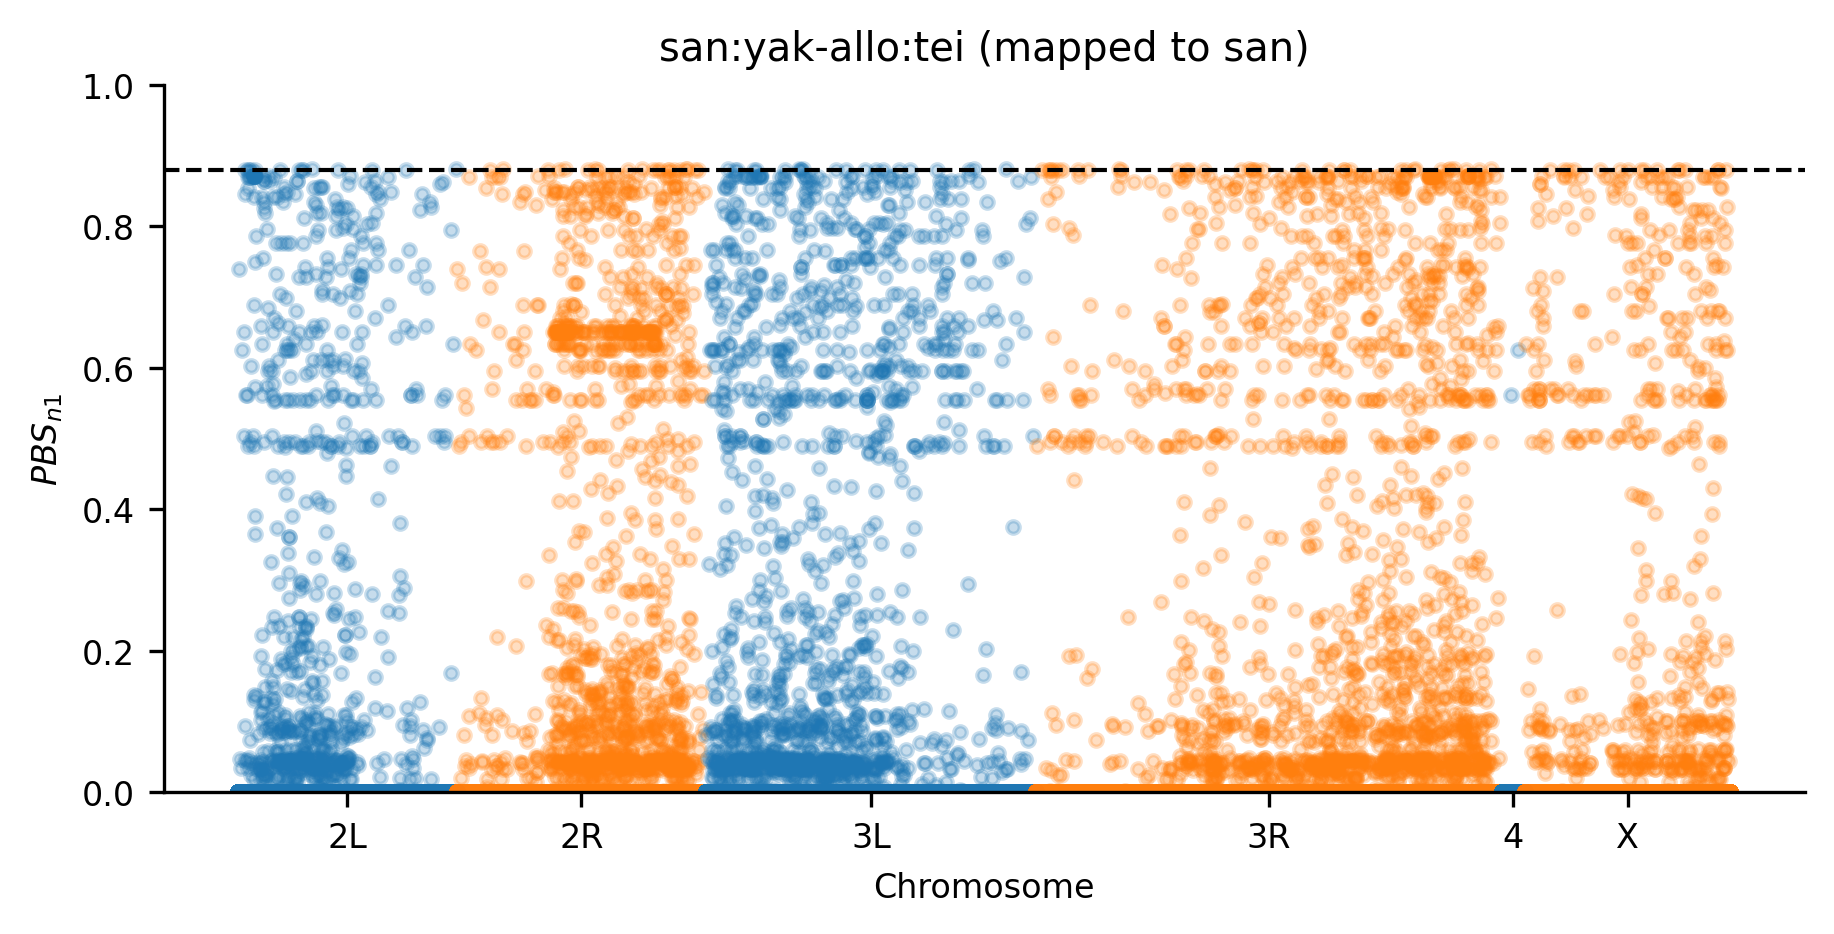

In [167]:
plot_genome_pbs(
    san_genome_dicc, 'san:yak-allo:tei',
    'san:yak-allo:tei (mapped to san)',
    'san_yak_allo_tei_map_san_pbs',
)

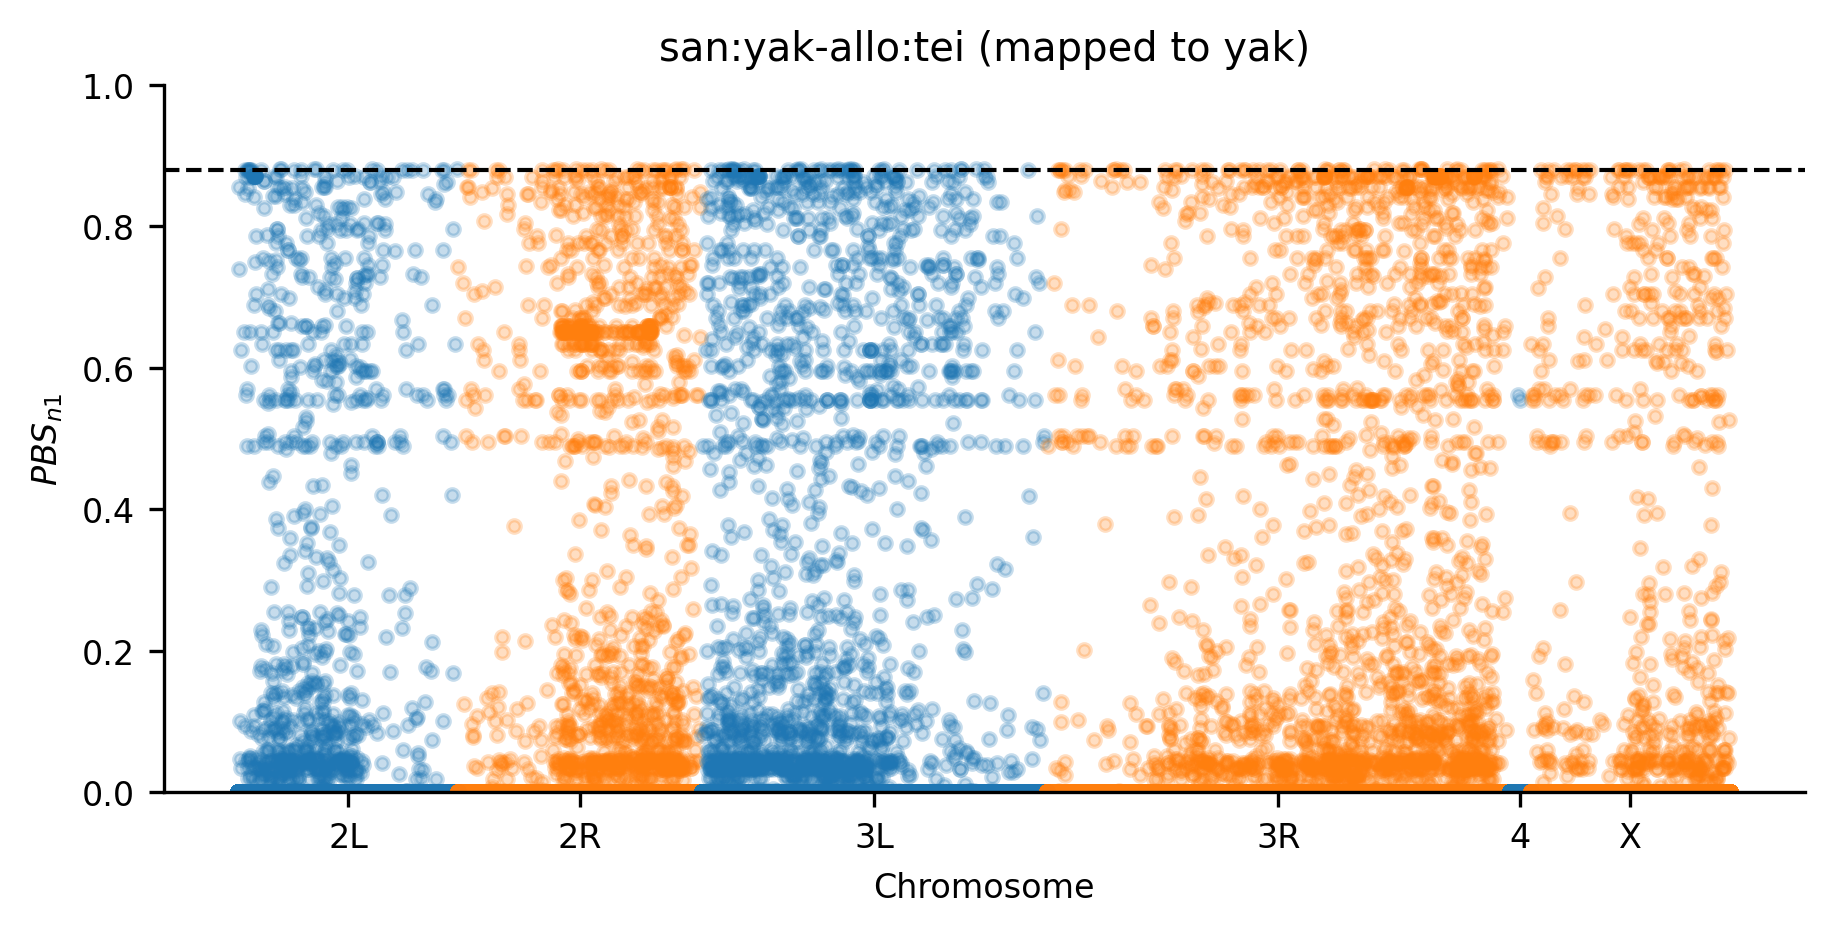

In [168]:
plot_genome_pbs(
    yak_genome_dicc, 'san:yak-allo:tei',
    'san:yak-allo:tei (mapped to yak)',
    'san_yak_allo_tei_map_yak_pbs',
)

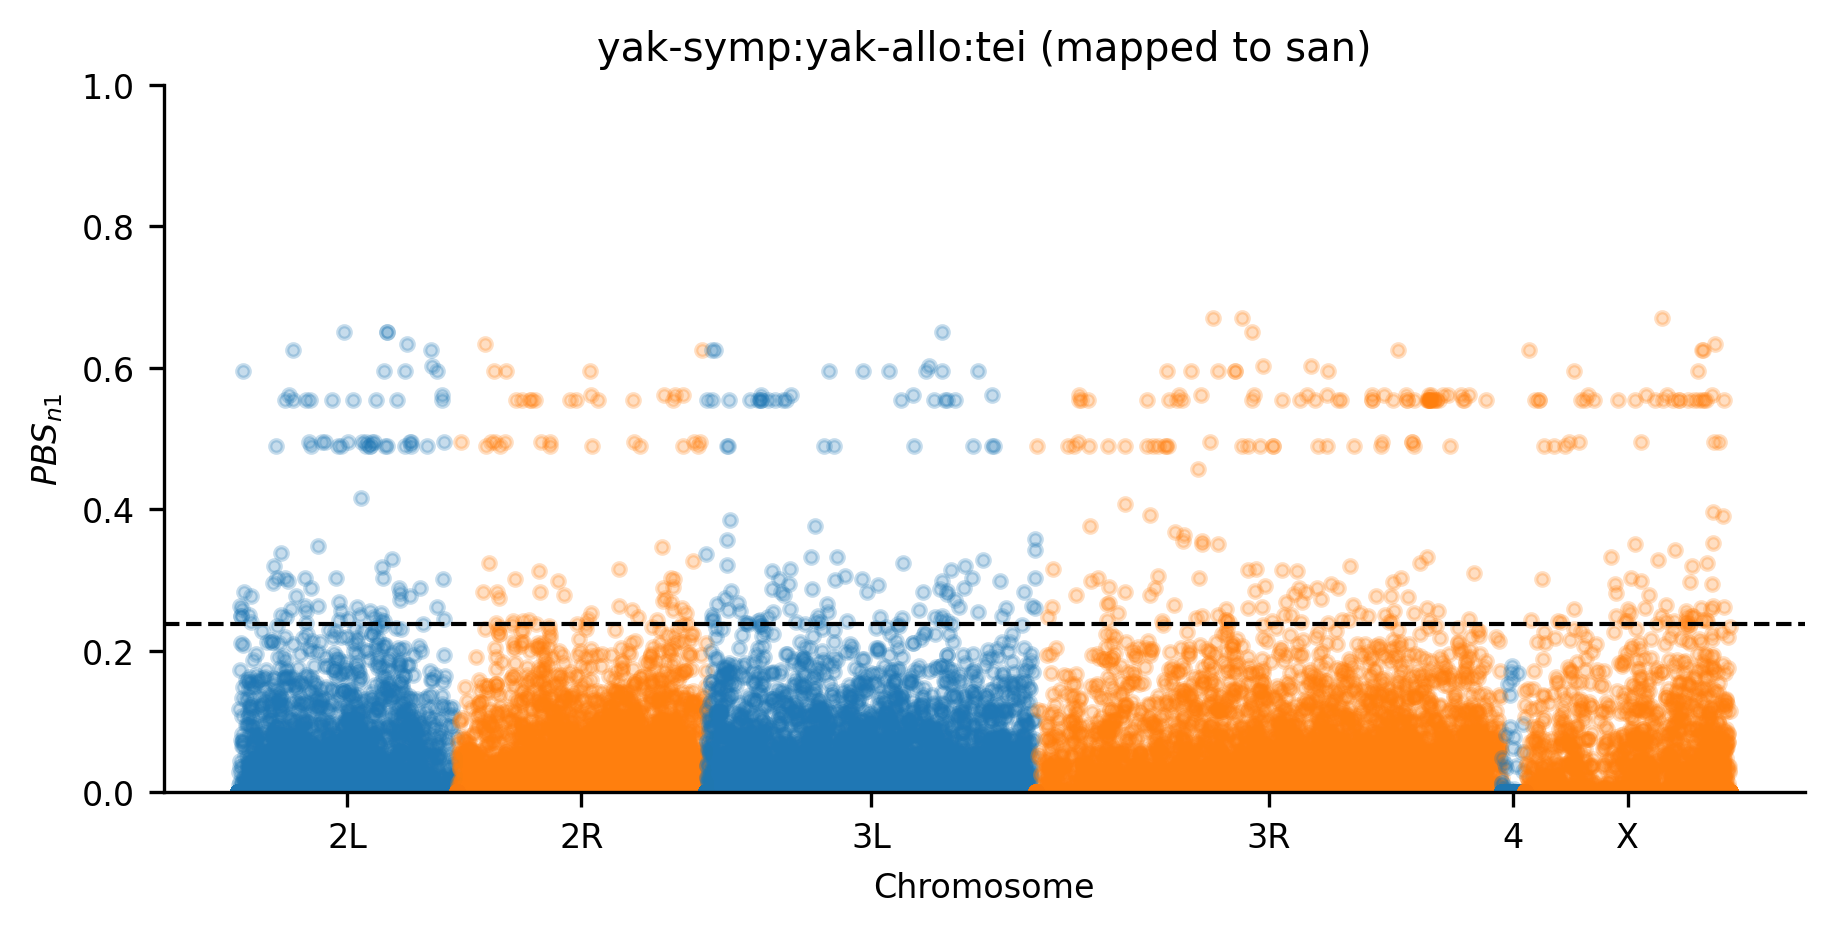

In [169]:
plot_genome_pbs(
    san_genome_dicc, 'yak-symp:yak-allo:tei',
    'yak-symp:yak-allo:tei (mapped to san)',
    'yak_symp_yak_allo_tei_map_san_pbs',
)

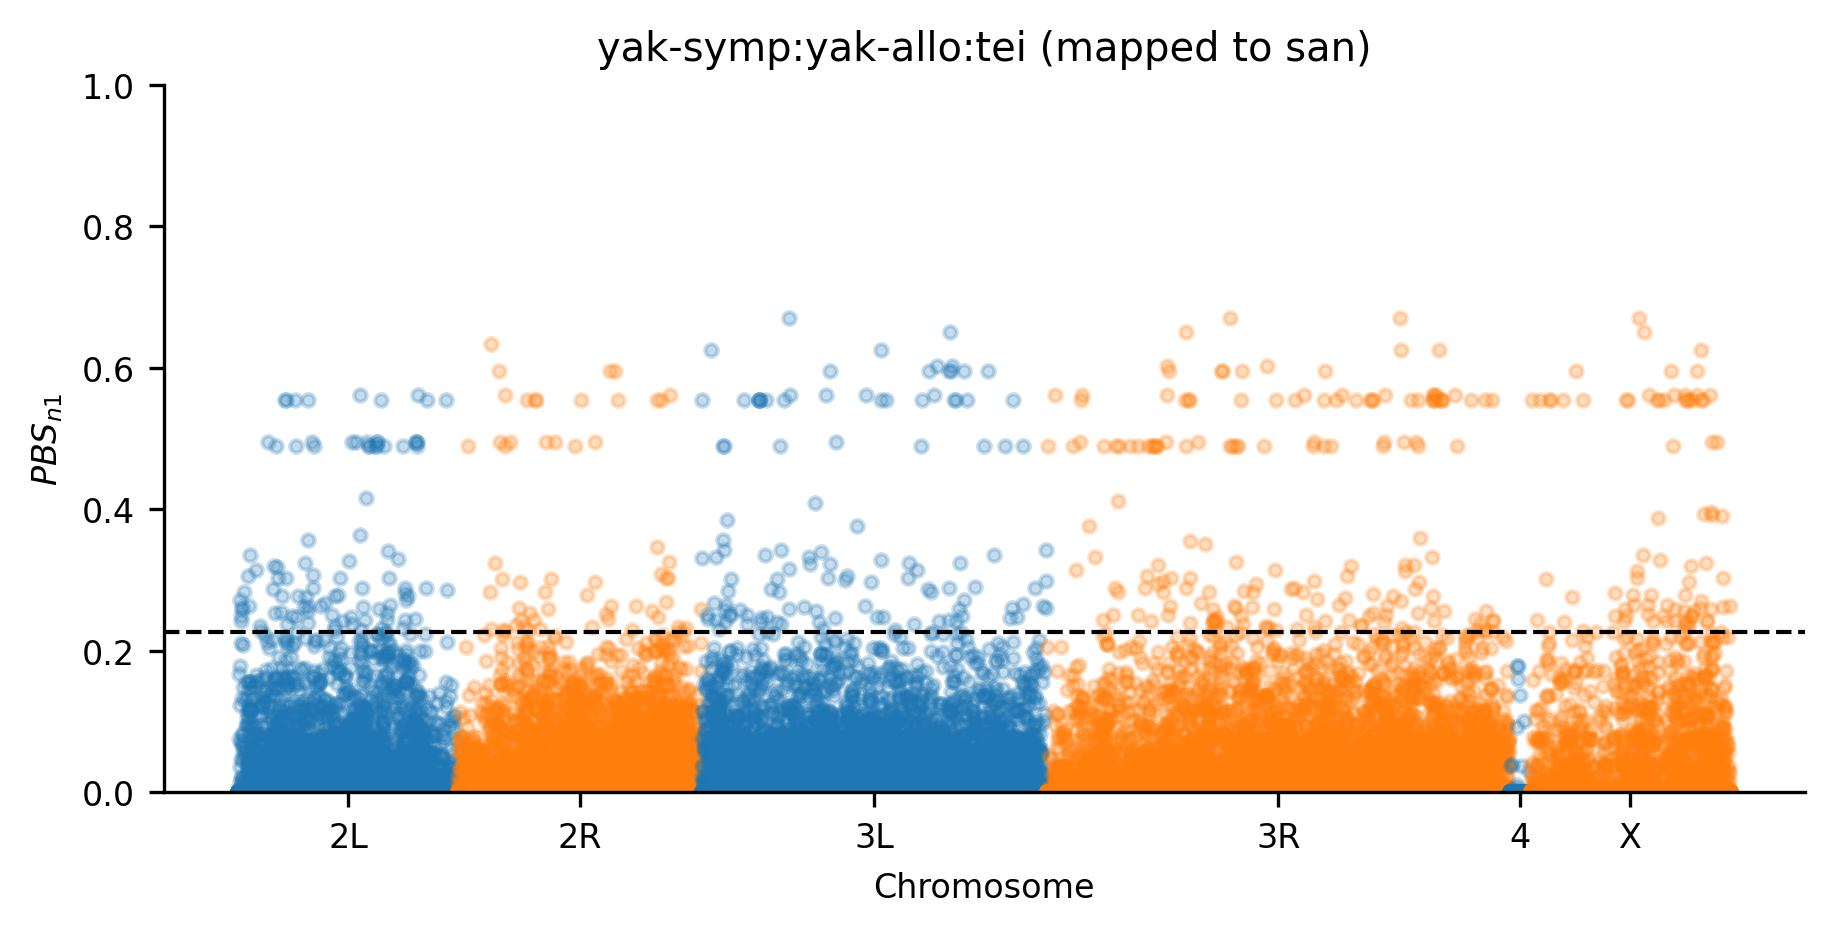

In [170]:
plot_genome_pbs(
    yak_genome_dicc, 'yak-symp:yak-allo:tei',
    'yak-symp:yak-allo:tei (mapped to san)',
    'yak_symp_yak_allo_tei_map_yak_pbs',
)

## Ortholog-level PBS

In [171]:
# Define a function to load the bootstrapped PBS values.
def load_bootstrap_pbs(prefix):
    # Load the bootstrapped matrix.
    bs_mat = np.loadtxt(f'./results/{prefix}/bootstrap_pbs.csv', delimiter=',', dtype=object)
    # Intialize a dictionary.
    pbs_dicc = {
        'san:yak-symp:yak-allo': np.where(np.isnan(bs_mat[:, 3].astype(float)), 0, bs_mat[:, 3].astype(float)),
        'san:yak-symp:tei': np.where(np.isnan(bs_mat[:, 4].astype(float)), 0, bs_mat[:, 4].astype(float)),
        'san:yak-allo:tei': np.where(np.isnan(bs_mat[:, 5].astype(float)), 0, bs_mat[:, 5].astype(float)),
        'yak-symp:yak-allo:tei': np.where(np.isnan(bs_mat[:, 6].astype(float)), 0, bs_mat[:, 6].astype(float)),
    }
    return pbs_dicc

In [172]:
# Define a function to load the per gene estimates.
def load_ortholog_pbs(prefix):
    # Load the results matrix.
    ortho_mat = np.loadtxt(f'./results/{prefix}/ortholog_pbs.csv', delimiter=',')
    # Intialize a dictionary.
    pbs_dicc = {
        'san:yak-symp:yak-allo': {'pbs': np.where(np.isnan(ortho_mat[:, 0]), 0, ortho_mat[:, 0])},
        'san:yak-symp:tei': {'pbs': np.where(np.isnan(ortho_mat[:, 1]), 0, ortho_mat[:, 0])},
        'san:yak-allo:tei': {'pbs': np.where(np.isnan(ortho_mat[:, 2]), 0, ortho_mat[:, 0])},
        'yak-symp:yak-allo:tei': {'pbs': np.where(np.isnan(ortho_mat[:, 3]), 0, ortho_mat[:, 0])},
    }
    # Load the bootstrapped results.
    bs_dicc = load_bootstrap_pbs(prefix)
    # For every configuration.
    for key in pbs_dicc.keys():
        # Intialize a list for p-values.
        pval_list = []
        # For every ortholog.
        for idx in range(pbs_dicc[key]['pbs'].size):
            # Calculate the p-value.
            pval_list.append(np.count_nonzero(pbs_dicc[key]['pbs'][idx] < bs_dicc[key]) / 10_000)
        # Update the dictionary.
        pbs_dicc[key]['pval'] = np.array(pval_list)
    return pbs_dicc

In [173]:
# Load the ortholog results.
san_ortho_dicc = load_ortholog_pbs('san')
yak_ortho_dicc = load_ortholog_pbs('yak')

In [174]:
# Load the ortholog data frame.
san_ortho_df = pd.read_csv(
    '../annotations/san_ortholog_qc_passed_coords.txt', sep='\t', usecols=[0, 1, 2, 3],
    names=['gene_id', 'chr', 'start', 'end'],
)
# Map the gene names.
san_ortho_df['gene'] = san_ortho_df['gene_id'].map(san_map_dicc)
# For every configuration.
for key in san_ortho_dicc.keys():
    # Append the dataframe.
    san_ortho_df[key+'_pbs'] = san_ortho_dicc[key]['pbs']
    san_ortho_df[key+'_pval'] = san_ortho_dicc[key]['pval']

In [175]:
# Load the ortholog data frame.
yak_ortho_df = pd.read_csv(
    '../annotations/yak_ortholog_qc_passed_coords.txt', sep='\t', usecols=[0, 1, 2, 3],
    names=['gene_id', 'chr', 'start', 'end'],
)
# Map the gene names.
yak_ortho_df['gene'] = yak_ortho_df['gene_id'].map(yak_map_dicc)
# For every configuration.
for key in yak_ortho_dicc.keys():
    # Append the dataframe.
    yak_ortho_df[key+'_pbs'] = yak_ortho_dicc[key]['pbs']
    yak_ortho_df[key+'_pval'] = yak_ortho_dicc[key]['pval']

In [176]:
# Extract the gene ids.
san_gene_ids = san_ortho_df['gene_id'].values
# Create gene family masks.
san_obp_mask = np.isin(san_gene_ids, gene_family_dicc['san']['obp'])
san_or_mask = np.isin(san_gene_ids, gene_family_dicc['san']['or'])
san_gr_mask = np.isin(san_gene_ids, gene_family_dicc['san']['gr'])
san_ir_mask = np.isin(san_gene_ids, gene_family_dicc['san']['ir'])
# Compile gene family dataframes.
san_obp_df = san_ortho_df[san_obp_mask]
san_or_df = san_ortho_df[san_or_mask]
san_gr_df = san_ortho_df[san_gr_mask]
san_ir_df = san_ortho_df[san_ir_mask]
# Concatenate the dataframe.
san_olfac_gene_df = pd.concat(
    [san_obp_df, san_or_df, san_gr_df, san_ir_df],
    axis=0, ignore_index=True,
)

In [177]:
# Extract the gene ids.
yak_gene_ids = yak_ortho_df['gene_id'].values
# Create gene family masks.
yak_obp_mask = np.isin(yak_gene_ids, gene_family_dicc['yak']['obp'])
yak_or_mask = np.isin(yak_gene_ids, gene_family_dicc['yak']['or'])
yak_gr_mask = np.isin(yak_gene_ids, gene_family_dicc['yak']['gr'])
yak_ir_mask = np.isin(yak_gene_ids, gene_family_dicc['yak']['ir'])
# Compile gene family dataframes.
yak_obp_df = yak_ortho_df[yak_obp_mask]
yak_or_df = yak_ortho_df[yak_or_mask]
yak_gr_df = yak_ortho_df[yak_gr_mask]
yak_ir_df = yak_ortho_df[yak_ir_mask]
# Concatenate the dataframe.
yak_olfac_gene_df = pd.concat(
    [yak_obp_df, yak_or_df, yak_gr_df, yak_ir_df],
    axis=0, ignore_index=True,
)

In [178]:
# # Export the dataframes.
# san_ortho_df.to_csv('./tables/san_all_orthologs_pbs.txt', sep='\t', header=True, index=False)
# san_olfac_gene_df.to_csv('./tables/san_olfactory_orthologs_pbs.txt', sep='\t', header=True, index=False)
# yak_ortho_df.to_csv('./tables/yak_all_orthologs_pbs.txt', sep='\t', header=True, index=False)
# yak_olfac_gene_df.to_csv('./tables/yak_olfactory_orthologs_pbs.txt', sep='\t', header=True, index=False)